# Samples per feature dependence

How do power, association strength as well as errors in weights, scores and loadings depend on sample size?

## Setup

In [1]:
import numpy as np
import xarray as xr
import scipy.linalg
import scipy.stats
from scipy.stats import pearsonr, zscore
from scipy.spatial.distance import pdist, cdist, squareform

from sklearn import clone
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit

from gemmr.data import load_outcomes, print_ds_stats
from gemmr.metrics import *
from gemmr.sample_size.interpolation import *
from gemmr.plot import mean_metric_curve

import matplotlib
import holoviews as hv
from holoviews import opts
hv.extension('matplotlib')
hv.renderer('matplotlib').set_param(dpi=120)

from my_config import *

import warnings
from matplotlib import MatplotlibDeprecationWarning
warnings.simplefilter('ignore', MatplotlibDeprecationWarning)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

In [2]:
rs = [.1, .3, .5]

In [3]:
r_clrs = hv.Palette(cmap_r, samples=len(rs)).values

In [4]:
ds_cca = load_outcomes('cca').sel(mode=0)
ds_pls = load_outcomes('pls', tag='axPlusay-2').sel(mode=0)

What's in the outcome data files?

In [5]:
print_ds_stats(ds_cca)

n_rep		 100
n_per_ftr	 [   3    4    8   16   32   64  128  256  512 1024]
r		 [0.1 0.3 0.5 0.7 0.9]
px		 [  2   4   8  16  32  64 128]
ax+ay range	(0.00, 0.00)
py		== px

<xarray.DataArray 'n_Sigmas' (px: 7, r: 5)>
array([[25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25],
       [ 0, 25, 25, 25, 25],
       [ 0, 25, 25, 25, 25]])
Coordinates:
  * r        (r) float64 0.1 0.3 0.5 0.7 0.9
  * px       (px) int64 2 4 8 16 32 64 128

power		calculated


In [6]:
print_ds_stats(ds_pls)

n_rep		 100
n_per_ftr	 [   3    4    8   16   32   64  128  256  512 1024 2048 4096 8192]
r		 [0.1 0.3 0.5 0.7 0.9]
px		 [  2   4   8  16  32  64 128]
ax+ay range	(-2.00, -2.00)
py		== px

<xarray.DataArray 'n_Sigmas' (px: 7, r: 5)>
array([[25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25],
       [25, 25, 25, 25, 25],
       [ 0, 25, 25, 25, 25],
       [ 0, 25, 25, 25, 25],
       [ 0,  0,  0, 25, 25],
       [ 0,  0,  0, 25, 25]])
Coordinates:
  * r        (r) float64 0.1 0.3 0.5 0.7 0.9
  * px       (px) int64 2 4 8 16 32 64 128

power		calculated


## Figure

/anaconda3/envs/gemmrtest/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


:Layout
   .Overlay.I    :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Power)
      .Curve.II  :Curve   [Samples per feature]   (Power)
      .Curve.III :Curve   [Samples per feature]   (Power)
      .VLine.I   :VLine   [x,y]
      .Text.I    :Text   [x,y]
      .Text.II   :Text   [x,y]
      .Text.III  :Text   [x,y]
      .Text.IV   :Text   [x,y]
      .Text.V    :Text   [x,y]
   .Overlay.II   :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Power)
      .Curve.II  :Curve   [Samples per feature]   (Power)
      .Curve.III :Curve   [Samples per feature]   (Power)
      .VLine.I   :VLine   [x,y]
      .Text.I    :Text   [x,y]
   .Overlay.III  :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Association strength)
      .Curve.II  :Curve   [Samples per feature]   (Association strength)
      .Curve.III :Curve   [Samples per feature]   (Association strength)
      .VLine.I   :VLine   [x,y]
      .HLine.I   :HLine   [x,y]
      .HLine.II  :HLine   [x,y]
      .HLine.III :HLine   [x,y]
      .Text.I    :Text   [x,y]
      .Text.II   :Text   [x,y]
      .Text.III  :Text   [x,y]
      .Text.IV   :Text   [x,y]
   .Overlay.IV   :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Assoc strength2)
      .Curve.II  :Curve   [Samples per feature]   (Assoc strength2)
      .Curve.III :Curve   [Samples per feature]   (Assoc strength2)
      .VLine.I   :VLine   [x,y]
      .HLine.I   :HLine   [x,y]
      .HLine.II  :HLine   [x,y]
      .HLine.III :HLine   [x,y]
      .Text.I    :Text   [x,y]
      .Text.II   :Text   [x,y]
      .Text.III  :Text   [x,y]
      .Text.IV   :Text   [x,y]
   .Overlay.V    :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Weight error)
      .Curve.II  :Curve   [Samples per feature]   (Weight error)
      .Curve.III :Curve   [Samples per feature]   (Weight error)
      .VLine.I   :VLine   [x,y]
   .Overlay.VI   :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Weight error)
      .Curve.II  :Curve   [Samples per feature]   (Weight error)
      .Curve.III :Curve   [Samples per feature]   (Weight error)
      .VLine.I   :VLine   [x,y]
   .Overlay.VII  :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Score error)
      .Curve.II  :Curve   [Samples per feature]   (Score error)
      .Curve.III :Curve   [Samples per feature]   (Score error)
      .VLine.I   :VLine   [x,y]
   .Overlay.VIII :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Score error)
      .Curve.II  :Curve   [Samples per feature]   (Score error)
      .Curve.III :Curve   [Samples per feature]   (Score error)
      .VLine.I   :VLine   [x,y]
   .Overlay.IX   :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Loading error)
      .Curve.II  :Curve   [Samples per feature]   (Loading error)
      .Curve.III :Curve   [Samples per feature]   (Loading error)
      .VLine.I   :VLine   [x,y]
   .Overlay.X    :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Loading error)
      .Curve.II  :Curve   [Samples per feature]   (Loading error)
      .Curve.III :Curve   [Samples per feature]   (Loading error)
      .VLine.I   :VLine   [x,y]
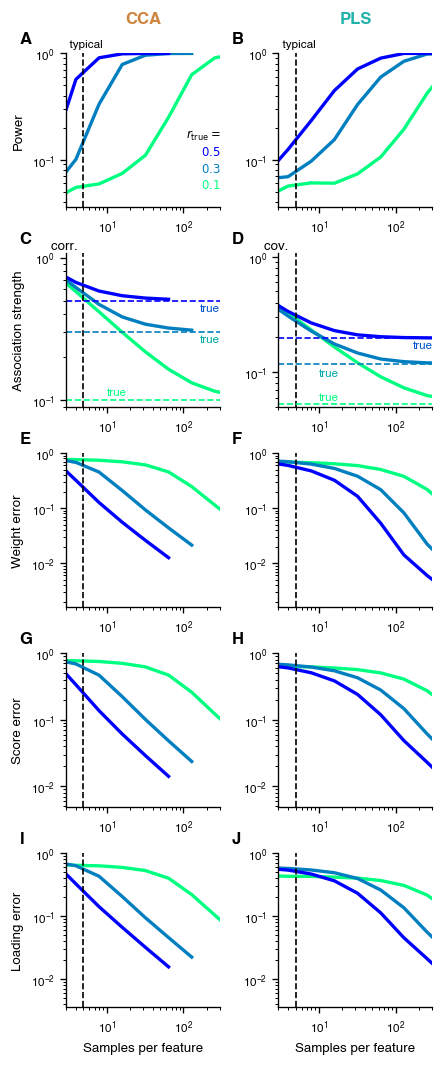

In [7]:
def format_assocStrength_axis(plot, element):
    yax = plot.handles['axis'].yaxis
    yax.set_minor_formatter(matplotlib.ticker.NullFormatter())
    yax.set_minor_locator(matplotlib.ticker.LogLocator(subs=(2,3,4,5,6,7,8,9)))
    yax.set_major_formatter(matplotlib.ticker.LogFormatterSciNotation())
    yax.set_major_locator(matplotlib.ticker.LogLocator(subs=(1,)))
    
    
fig = (
    # --- power ---
    (
        mean_metric_curve(ds_cca.power, ylabel='Power')
        * hv.Text(300, 0.2, r'$r_\mathrm{true}=$', fontsize=7, halign='right', valign='top')
        * hv.Text(300, 0.2*(.7)**1, r'$0.5$', fontsize=7, halign='right', valign='top').opts(color=r_clrs[2])
        * hv.Text(300, 0.2*(.7)**2, r'$0.3$', fontsize=7, halign='right', valign='top').opts(color=r_clrs[1])
        * hv.Text(300, 0.2*(.7)**3, r'$0.1$', fontsize=7, halign='right', valign='top').opts(color=r_clrs[0])
        * hv.Text(n_per_ftr_typical, 1.1, '  typical', fontsize=7, halign='center', valign='bottom')

    ).opts(xlabel='', ylim=(None, 1.01), hooks=[suptitle_cca])
    + (
        mean_metric_curve(ds_pls.power, ylabel='Power')
        * hv.Text(n_per_ftr_typical, 1.1, '  typical', fontsize=7, halign='center', valign='bottom')
    ).opts(xlabel='', ylabel='', ylim=(None, 1.01), hooks=[suptitle_pls])
    # --- association strength ---
    + (
        mean_metric_curve(ds_cca.between_assocs, ylabel='Association strength')
        * hv.HLine(.1)
        * hv.HLine(.3)
        * hv.HLine(.5)
        * (
            hv.Text(10, .105, 'true', fontsize=7, halign='left', valign='bottom')
            * hv.Text(300, .29, 'true', fontsize=7, halign='right', valign='top')
            * hv.Text(300, .48, 'true', fontsize=7, halign='right', valign='top')
        ).opts(opts.Text(color=hv.Palette(cmap_r)))
        * hv.Text(3, 1.1, 'corr. ', fontsize=8, halign='center', valign='bottom').opts(color='black')
    ).opts(xlabel='', yticks=5, ylim=(.09, 1.075), hooks=[format_assocStrength_axis])
    + (
        mean_metric_curve(ds_pls.between_assocs, ylabel='Assoc strength2')
        * hv.HLine(float(ds_pls.between_assocs_true.sel(r=0.1).mean('px').mean('Sigma_id')))
        * hv.HLine(float(ds_pls.between_assocs_true.sel(r=0.3).mean('px').mean('Sigma_id')))
        * hv.HLine(float(ds_pls.between_assocs_true.sel(r=0.5).mean('px').mean('Sigma_id')))
        * (
            hv.Text(10, .055, 'true', fontsize=7, halign='left', valign='bottom')
            * hv.Text(10, .108, 'true', fontsize=7, halign='left', valign='top')
            * hv.Text(300, .19, 'true', fontsize=7, halign='right', valign='top')
        ).opts(opts.Text(color=hv.Palette(cmap_r)))
        * hv.Text(3, 1.1, 'cov. ', fontsize=8, halign='center', valign='bottom').opts(color='black')
    ).opts(xlabel='', ylabel='', yticks=5, ylim=(5e-2, 1.075), hooks=[format_assocStrength_axis])
    # --- other error metrics ---
    + mean_metric_curve(mk_weightError(ds_cca), ylabel='Weight error').opts(xlabel='', ylim=(None, 1))
    + mean_metric_curve(mk_weightError(ds_pls), ylabel='Weight error').opts(xlabel='', ylabel='', ylim=(None, 1))
    + mean_metric_curve(mk_scoreError(ds_cca), ylabel='Score error').opts(xlabel='', ylim=(None, 1))
    + mean_metric_curve(mk_scoreError(ds_pls), ylabel='Score error').opts(xlabel='', ylabel='', ylim=(None, 1))
    + mean_metric_curve(mk_loadingError(ds_cca), ylabel='Loading error').opts(ylim=(None, 1))
    + mean_metric_curve(mk_loadingError(ds_pls), ylabel='Loading error').opts(ylabel='', ylim=(None, 1))
).redim(
    n_per_ftr='Samples per feature'
).cols(
    2
).opts(*fig_opts).opts(
    opts.Curve(color=hv.Palette(cmap_r)),
    opts.HLine(color=hv.Palette(cmap_r), linewidth=1, linestyle='--'),
    opts.VLine(color='black', linestyle='--', linewidth=1),
    opts.Overlay(logx=True, logy=True, xlim=(3, 300), sublabel_position=(-.4, .95)),
    opts.Layout(hspace=.35),
)

hv.save(fig, 'fig/fig2_samples_per_feature_dependence.pdf')

fig

Alternative view

/anaconda3/envs/gemmrtest/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


:Layout
   .Overlay.CCA  :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Power)
      .Curve.II  :Curve   [Samples per feature]   (Power)
      .Curve.III :Curve   [Samples per feature]   (Power)
      .HLine.I   :HLine   [x,y]
      .Text.I    :Text   [x,y]
      .Text.II   :Text   [x,y]
      .Text.III  :Text   [x,y]
      .Text.IV   :Text   [x,y]
   .Overlay.I    :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Power)
      .Curve.II  :Curve   [Samples per feature]   (Power)
      .Curve.III :Curve   [Samples per feature]   (Power)
      .HLine.I   :HLine   [x,y]
   .Overlay.II   :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Association strength)
      .Curve.II  :Curve   [Samples per feature]   (Association strength)
      .Curve.III :Curve   [Samples per feature]   (Association strength)
      .VLine.I   :VLine   [x,y]
      .HLine.I   :HLine   [x,y]
   .Overlay.III  :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Assoc strength2)
      .Curve.II  :Curve   [Samples per feature]   (Assoc strength2)
      .Curve.III :Curve   [Samples per feature]   (Assoc strength2)
      .HLine.I   :HLine   [x,y]
   .Overlay.IV   :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Weight error)
      .Curve.II  :Curve   [Samples per feature]   (Weight error)
      .Curve.III :Curve   [Samples per feature]   (Weight error)
      .HLine.I   :HLine   [x,y]
   .Overlay.V    :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Weight error)
      .Curve.II  :Curve   [Samples per feature]   (Weight error)
      .Curve.III :Curve   [Samples per feature]   (Weight error)
      .HLine.I   :HLine   [x,y]
   .Overlay.VI   :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Score error)
      .Curve.II  :Curve   [Samples per feature]   (Score error)
      .Curve.III :Curve   [Samples per feature]   (Score error)
      .HLine.I   :HLine   [x,y]
   .Overlay.VII  :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Score error)
      .Curve.II  :Curve   [Samples per feature]   (Score error)
      .Curve.III :Curve   [Samples per feature]   (Score error)
      .HLine.I   :HLine   [x,y]
   .Overlay.VIII :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Loading error)
      .Curve.II  :Curve   [Samples per feature]   (Loading error)
      .Curve.III :Curve   [Samples per feature]   (Loading error)
      .HLine.I   :HLine   [x,y]
   .Overlay.IX   :Overlay
      .Curve.I   :Curve   [Samples per feature]   (Loading error)
      .Curve.II  :Curve   [Samples per feature]   (Loading error)
      .Curve.III :Curve   [Samples per feature]   (Loading error)
      .HLine.I   :HLine   [x,y]
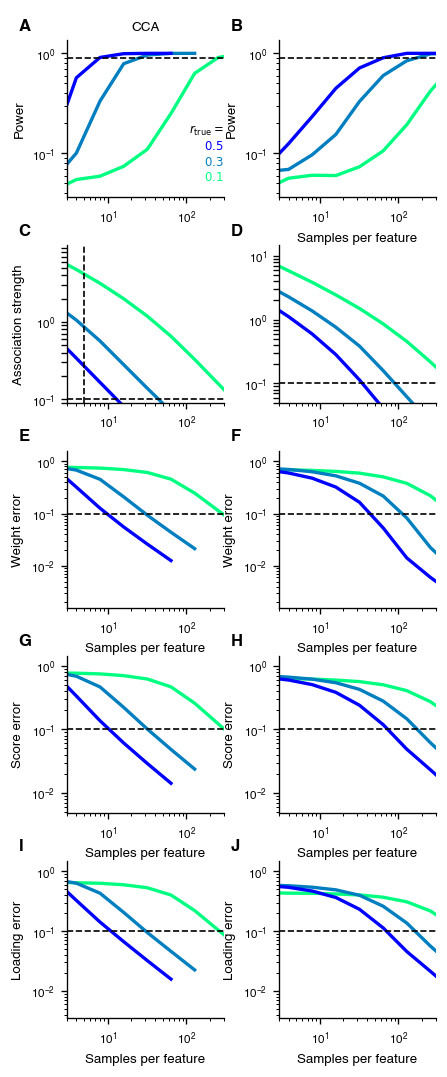

In [8]:
fig = (
    (
        mean_metric_curve(ds_cca.power, ylabel='Power', n_per_ftr_typical=None)
        * hv.HLine(.9)
        * hv.Text(300, 0.2, r'$r_\mathrm{true}=$', fontsize=7, halign='right', valign='top')
        * hv.Text(300, 0.2*(.7)**1, r'$0.5$', fontsize=7, halign='right', valign='top').opts(color=r_clrs[2])
        * hv.Text(300, 0.2*(.7)**2, r'$0.3$', fontsize=7, halign='right', valign='top').opts(color=r_clrs[1])
        * hv.Text(300, 0.2*(.7)**3, r'$0.1$', fontsize=7, halign='right', valign='top').opts(color=r_clrs[0])

    ).relabel('CCA').opts(xlabel='')
    + (
        mean_metric_curve(ds_pls.power, ylabel='Power', n_per_ftr_typical=None).relabel('PLS').opts(xlabel='', ylabel='')
        * hv.HLine(.9)
    )
    + (
        mean_metric_curve(mk_betweenAssocRelError(ds_cca), ylabel='Association strength')
        * hv.HLine(.1)
    ).opts(xlabel='', yticks=5, ylim=(.09, None))
    + (
        mean_metric_curve(mk_betweenAssocRelError(ds_pls), ylabel='Assoc strength2', n_per_ftr_typical=None)
        * hv.HLine(0.1)
    ).opts(xlabel='', ylabel='', yticks=5, ylim=(5e-2, None))
    + (
        mean_metric_curve(mk_weightError(ds_cca), ylabel='Weight error', n_per_ftr_typical=None).opts(xlabel='', ylim=(None, 1))
        * hv.HLine(.1)
    )
    + (
        mean_metric_curve(mk_weightError(ds_pls), ylabel='Weight error', n_per_ftr_typical=None).opts(xlabel='', ylabel='', ylim=(None, 1))
        * hv.HLine(.1)
    )
    + (
        mean_metric_curve(mk_scoreError(ds_cca), ylabel='Score error', n_per_ftr_typical=None).opts(xlabel='', ylim=(None, 1))
        * hv.HLine(.1)
    )
    + (
        mean_metric_curve(mk_scoreError(ds_pls), ylabel='Score error', n_per_ftr_typical=None).opts(xlabel='', ylabel='', ylim=(None, 1))
        * hv.HLine(.1)
    )
    + (
        mean_metric_curve(mk_loadingError(ds_cca), ylabel='Loading error', n_per_ftr_typical=None).opts(ylim=(None, 1))
        * hv.HLine(.1)
    )
    + (
        mean_metric_curve(mk_loadingError(ds_pls), ylabel='Loading error', n_per_ftr_typical=None).opts(ylabel='', ylim=(None, 1))
        * hv.HLine(.1)
    )
).redim(
    n_per_ftr='Samples per feature'
).cols(
    2
).opts(*fig_opts).opts(
    opts.Curve(color=hv.Palette(cmap_r)),
    opts.HLine(color='black', linewidth=1, linestyle='--'),
    opts.VLine(color='black', linestyle='--', linewidth=1),
    opts.Overlay(logx=True, logy=True, xlim=(3, 300), sublabel_position=(-.4, .95)),
    opts.Layout(hspace=.35),
)

hv.save(fig, 'fig/fig2alternative_samples_per_feature_dependence.png')

fig